In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from random import randrange
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

In [487]:
def z_norm(dataset):
    norm_data = dataset.T.copy()
    for idx, col in enumerate(norm_data):
        std = np.std(col)
        if std != 0.:
            norm_data[idx] = (col - np.mean(col)) / std
        
    return norm_data.T.astype("float")

def min_max(dataset):
    norm_data = dataset.T.copy()
    for idx, col in enumerate(norm_data):
        norm_data[idx] = (col - np.min(col)) / (np.max(col) - np.min(col))
        
    return norm_data.T.astype("float")

def to_categorical(labels):
    Class = np.unique(labels)
    target = list()
    for cls in labels:
        target.append(np.where(Class == cls)[0][0])
        
    return np.array(target), Class 

def one_hot_vector(labels):
    vector_labels = []
    for Class in labels:
        encode = [0 for i in range(len(list(set(labels))))]
        encode[Class] = 1
        vector_labels.append(encode)
    return np.array(vector_labels)

In [59]:
df = pd.read_csv("data.csv", header = None,  low_memory = False)
labels = pd.read_csv("labels.csv", header = None)
df = df.iloc[1:,1:]
labels = labels.iloc[1:,1:]
data = np.array(df, dtype = "float")
labels = labels.to_numpy().flatten()

norm_data = z_norm(data)
labels, Class = to_categorical(labels)

dataset = np.hstack((norm_data,labels.reshape(labels.size,1)))
     
np.random.shuffle(dataset)

In [316]:
class Sequential():
    
    def __init__(self):
        self.layers = list()
        self.activation_function = list()
        self.weights = list()
        self.bias = list()
        self.delta = list()
        self.activations = list()
        self.derivatives = list()
        self.prev_weights = list()
        
    def add(self, neurons, activation = None):
        if activation == None:
            self.layers.append(neurons)
        else:
            self.layers.append(neurons)
            self.activation_function.append(activation)
            
        if len(self.layers) > 1:
            w = np.random.uniform(low = -1, high = 1, size = (self.layers[len(self.layers) - 1 - 1], self.layers[len(self.layers) - 1]))
            self.weights.append(w)
            b = np.random.uniform(low = -1, high = 1, size = (self.layers[len(self.layers) - 1], ))
            self.bias.append(b)
            d = np.zeros(self.layers[len(self.layers) - 1])
            self.derivatives.append(d)
            a = np.zeros(self.layers[len(self.layers) - 1])
            self.activations.append(a)
            de = np.zeros(self.layers[len(self.layers) - 1])
            self.delta.append(de)
        else:
            a = np.zeros(self.layers[len(self.layers) - 1])
            self.activations.append(a)
            
        self.prev_weights = self.weights.copy()
            
    def summary(self):
        header = "Layers (type)     Activation     Output Shape     Param #"
        alignment = len(header) + 5
        print("Structure Neural Network:", self.layers)
        print("\n")
        print(header)
        print("="*alignment)
        param = [self.weights[0].size + self.bias[0].size]
        for i in range(len(self.layers)):
            if i == 0:
                print("Layer{0} (input)      None      (None, {1})         0".format(i, self.layers[i]))
                print("—"*alignment)
            elif i < len(self.layers) - 1:
                param.append(self.weights[i].size + self.bias[i].size)
                print("Layer{0} (dense)    {1}        (None, {2})      {3}".format(i, self.activation_function[i-1], self.layers[i], param[i - 1]))
                print("—"*alignment)
            else:
                print("Layer{0} (output)   {1}        (None, {2})         {3}".format(i, self.activation_function[-1], self.layers[i], param[-1]))
                print("="*alignment)
        print("total param:", sum(param))
        
        
    def sigmoid(self, x):
        return expit(x)
    
    def sigmoid_derivative(self, x):
        return x * (1.0 - x)
    
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis = 0)
    
    def softmax_derivative(self, x):
        s = x.reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)
    
    def forward_pass(self, inputs):
        activations = inputs
        self.activations[0] = activations
        for i, w in enumerate(self.weights):
            net = np.dot(activations, w) + self.bias[i]
            if self.activation_function[i] == "sigmoid":
                activations = self.sigmoid(net)
            elif self.activation_function[i] == "softmax":
                activations = self.softmax(net)
            self.activations[i+1] = activations
        
        return activations
    
    def backward_pass(self, desired_output, output):
        error = desired_output - output
        for i in reversed(range(len(self.derivatives))):
            activations = self.activations[i+1]
            if self.activation_function[i] == "sigmoid":
                delta = error * self.sigmoid_derivative(activations)
            elif self.activation_function[i] == "softmax":
                delta = error @ self.softmax_derivative(activations)
                
            self.delta[i] = delta
            delta_re = delta.reshape(delta.shape[0], -1).T
            current_activations = self.activations[i]
            current_activations = current_activations.reshape(current_activations.shape[0],-1)
            self.derivatives[i] = np.dot(current_activations, delta_re)
            error = np.dot(delta, self.weights[i].T)
            
    def cross_entropy(self, predicted, actual):
        return -np.sum(actual * np.log(predicted))
    
    def MAE(self, predicted, actual):
        return np.mean(abs(actual - predicted))
    
    def MSE(self, predicted, actual):
        return np.mean((actual - predicted) ** 2)
    
    def gradient_descent(self, lr = 1, mr = 0):
        for i in range(len(self.weights)):
            weights = self.weights[i]
            bias = self.bias[i]
            prev_weights = self.prev_weights[i]
            derivatives = self.derivatives[i]
            delta = self.delta[i]
            weights += (mr * (weights - prev_weights)) + (lr * derivatives)
            bias += lr * delta
            
    def fit(self, inputs, desired_outputs, epochs, metric, lr = 1, mr = 0):
        cost_function = ["cross_entropy", "mean_absolute_errors", "mean_square_errors"]
        assert (metric in cost_function), "cost funtion error: metric name"
        self.temp_weights = []
        error_avg = float('inf')
        for epoch in range(epochs):
            sum_error = 0.0
            if epoch > 1:
                self.prev_weights = self.temp_weights.copy()
            self.temp_weights = self.weights.copy()
            for j, inpt in enumerate(inputs):
                desired_output = desired_outputs[j]
                output = self.forward_pass(inpt)
                self.backward_pass(desired_output, output)
                self.gradient_descent(lr,mr)
                if metric == cost_function[0]:
                    sum_error += self.cross_entropy(output, desired_output)
                elif metric == cost_function[1]:
                    sum_error += self.MAE(output, desired_output)
                elif metric == cost_function[2]:
                    sum_error += self.MSE(output, desired_output)
            
            
            error_avg = sum_error / inputs.shape[0]
            print("epoch -> {}".format(epoch+1))
            print("Error_avg: {}".format(error_avg))
            
            
    def predict(self, test):
        predicted = []
        for unknown in test:
            predicted.append(np.argmax(self.forward_pass(unknown)))
        return np.array(predicted)

In [317]:
def create_model(n_inputs, hidden_layers, n_output, activation_function):
    assert len(hidden_layers) + 1 == len(activation_function), "Structure error:invalid hidden layer and activation function"
    model = Sequential()
    model.add(n_inputs)
    for idx, neurons in enumerate(hidden_layers):
        model.add(neurons, activation_function[idx])
    model.add(n_output, activation_function[-1])
    return model

def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return np.array(dataset_split)

def back_propagation(train, labels, learning_rate, momentum_rate, epochs, hidden_layers, n_outputs, activation_function):
    n_inputs = len(train[0])
    labels = one_hot_vector(labels)
    model = create_model(n_inputs, hidden_layers, n_outputs, activation_function)
    model.fit(train, labels, epochs, "cross_entropy", learning_rate, momentum_rate)
    print('='*250)
    return model

def evaluate_algorithm(dataset, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for i in range(n_folds):
        test = folds[i]
        train = np.array([fold for idx, fold in enumerate(folds) if idx != i ])
        train = train.reshape(-1, train.shape[-1])
        train, labels = get_labels(train)
        model = back_propagation(train, labels, *args)
#         save_model(model,i)
        test, actual = get_labels(test)
        predicted = model.predict(test)
        accuracy = confusion_matrix(actual, predicted)
        scores.append(accuracy)
    return scores, folds

In [318]:
def get_labels(data):
    return data[:,:-1], data[:,-1].astype('int')

def save_model(model,i):
    with open('model%i.pickle'%i, 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_model(file_name):
    with open(file_name, 'rb') as handle:
        model = pickle.load(handle)
    return model

def confusion_matrix(true, pred):
    K = len(np.unique(true))
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

def plot_confusion_matrix(cm, Class, idx):
    df_cm = pd.DataFrame(cm, index = [i for i in Class], columns = [i for i in Class])
    plt.figure(figsize = (10,7))
    plt.title("fold-%i"%(idx+1),fontsize = 20)
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True)
    
def get_accuracy(cm):
    return np.trace(cm) / np.sum(cm)

In [489]:
hidden_layer = [128]
activation = ['softmax', 'softmax']
epochs = 10
loss_function = "cross_entropy"
learning_rate = 0.1
momentum_rate = 0.55
n_folds = 10

In [65]:
# train = dataset[:720]
# test = dataset[720:]

# test, actual = get_labels(test)
# train, labels = get_labels(train)

# vector_labels = one_hot_vector(labels)

# model = create_model(train.shape[1], hidden_layer, Class.size, activation)

# model.summary()

# model.fit(train, vector_labels, epochs, loss_function, learning_rate, momentum_rate)

# predicted = model.predict(test)

# cm = confusion_matrix(predicted, actual)

In [ ]:
scores, folds = evaluate_algorithm(dataset, n_folds, learning_rate, momentum_rate, epochs, hidden_layer, Class.size, activation)

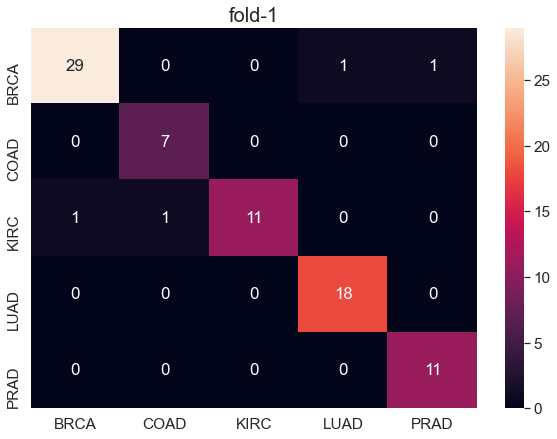

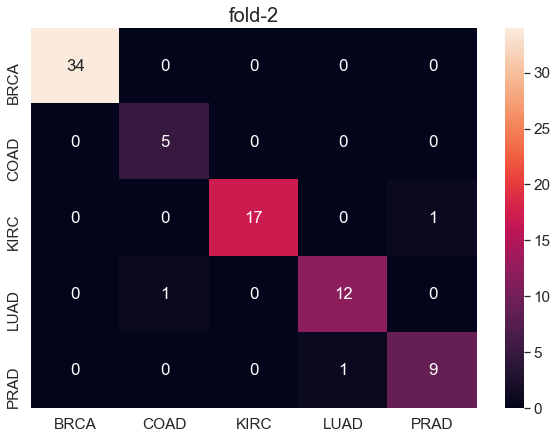

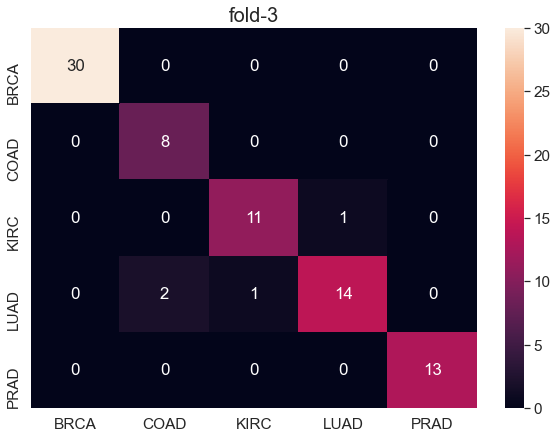

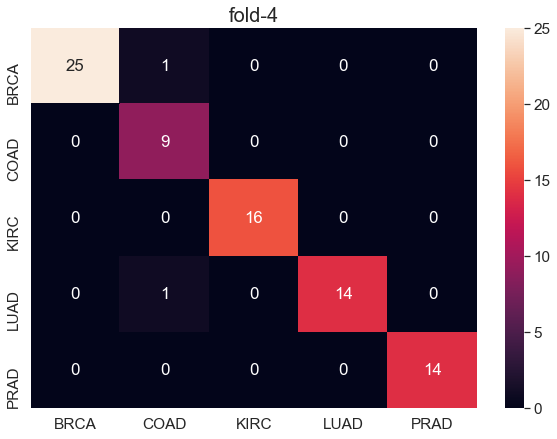

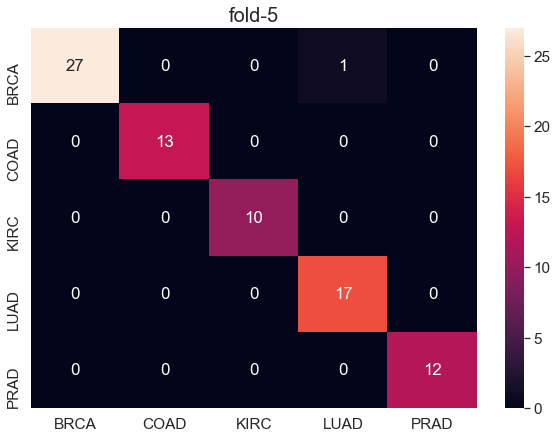

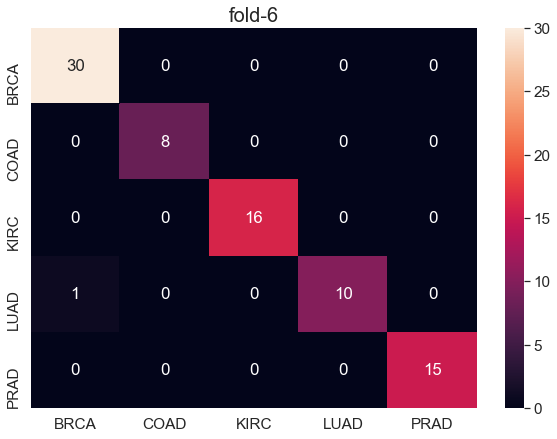

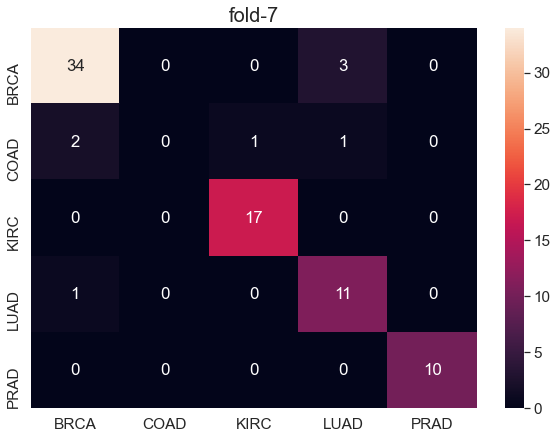

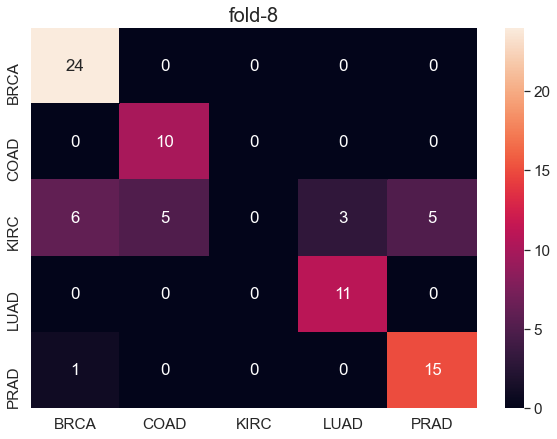

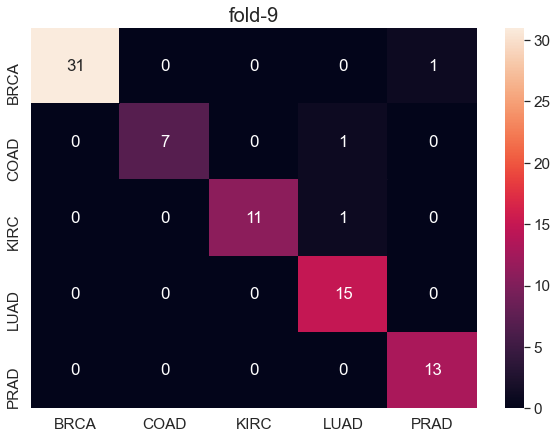

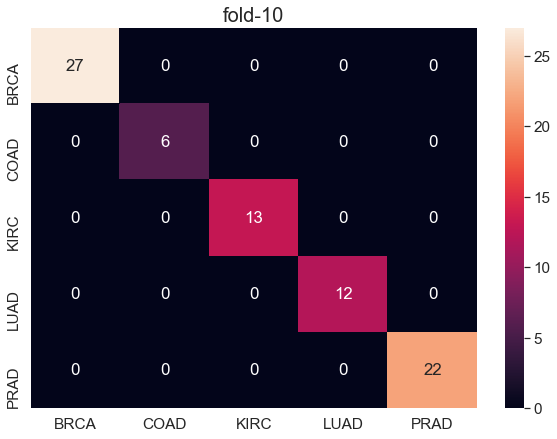

In [119]:
for idx, cm in enumerate(scores):
    plot_confusion_matrix(cm, Class, idx)

In [120]:
Class

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)